# 04.2 Confounding Bias: The Backdoor Problem

**Chapter**: 4 - Graphical Causal Models  
**Section**: 2 - Confounding  
**Facure Source**: 04-Graphical-Causal-Models.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [What is Confounding?](#11-what-is-confounding)
   - 1.2 [The Backdoor Path](#12-the-backdoor-path)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Backdoor Criterion](#21-backdoor-criterion)
   - 2.2 [Adjustment Formula](#22-adjustment-formula)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Confounding Simulation](#31-confounding-simulation)
   - 3.2 [Surrogate Confounders](#32-surrogate-confounders)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Confounding is THE central problem in observational causal inference. Every interview will test whether you can identify and address confounders.

### 1.1 What is Confounding?

Facure's example: **Education → Wage**

We observe: People with more education earn more. Is education **causing** higher wages?

**The problem**: Intelligence affects both:
- Smarter people get more education
- Smarter people earn more (even without education)

**Intelligence** is a **confounder**—a common cause of both treatment and outcome.

### 1.2 The Backdoor Path

In DAG terms:

```
Intelligence → Education
Intelligence → Wage
Education → Wage  (the causal effect we want)
```

There's a **backdoor path**: Education ← Intelligence → Wage

This path creates spurious association that mixes with the causal effect.

★ Insight ─────────────────────────────────────
- Confounding = common cause creates backdoor path
- Backdoor paths flow T ← ... → Y (arrow INTO treatment)
- Solution: Block all backdoor paths
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Backdoor Criterion

**Definition** (Pearl, 2009): A set of variables $Z$ satisfies the **backdoor criterion** relative to $(T, Y)$ if:

1. No node in $Z$ is a descendant of $T$
2. $Z$ blocks every path between $T$ and $Y$ that contains an arrow **into** $T$

**Implication**: If $Z$ satisfies the backdoor criterion, then:
$$P(Y \mid do(T=t)) = \sum_z P(Y \mid T=t, Z=z) P(Z=z)$$

### 2.2 Adjustment Formula

For continuous variables, the **adjustment formula** becomes:

$$E[Y \mid do(T=t)] = \int E[Y \mid T=t, Z=z] \, dP(Z=z)$$

In regression:
$$Y = \alpha + \tau T + \beta Z + \epsilon$$

The coefficient $\tau$ is the causal effect **if** Z satisfies the backdoor criterion.

**Conditional ignorability** (Rubin's framing):
$$(Y_0, Y_1) \perp\!\!\!\perp T \mid Z$$

This is equivalent to saying: given Z, treatment assignment is "as good as random."

---

## 3. Numeric Demonstration

### 3.1 Confounding Simulation

In [2]:
# Simulate confounding: Intelligence → Education, Intelligence → Wage, Education → Wage
np.random.seed(42)
n = 2000

# True causal effect of education on wage
TRUE_EFFECT = 5.0  # Each year of education increases wage by $5k

# Confounder: Intelligence (unobserved IQ)
intelligence = np.random.normal(100, 15, n)

# Treatment: Years of education (affected by intelligence)
education = 10 + 0.1 * (intelligence - 100) + np.random.normal(0, 2, n)
education = np.clip(education, 0, 20)  # 0-20 years

# Outcome: Wage (affected by both intelligence AND education)
wage = 30 + TRUE_EFFECT * education + 0.5 * (intelligence - 100) + np.random.normal(0, 10, n)

df = pd.DataFrame({
    'intelligence': intelligence,
    'education': education,
    'wage': wage,
})

print("SIMULATED DATA")
print("="*50)
print(f"True causal effect of education: {TRUE_EFFECT}")
print(f"Sample size: {n}")
print(df.describe().round(2))

SIMULATED DATA
True causal effect of education: 5.0
Sample size: 2000
       intelligence  education      wage
count     2000.0000  2000.0000 2000.0000
mean       100.6800    10.0500   80.1300
std         14.8300     2.4800   20.5300
min         51.3800     1.9800   15.4900
25%         90.6600     8.3600   65.8100
50%        100.6700    10.0500   80.2900
75%        110.2400    11.7000   94.5200
max        157.7900    18.8300  144.2400


In [3]:
# Naive estimate: Regress wage on education (ignoring intelligence)
naive_model = sm.OLS(df['wage'], sm.add_constant(df['education'])).fit()

# Adjusted estimate: Regress wage on education AND intelligence
adjusted_model = sm.OLS(df['wage'], sm.add_constant(df[['education', 'intelligence']])).fit()

print("CONFOUNDING DEMONSTRATION")
print("="*60)
print(f"True causal effect:       {TRUE_EFFECT:.2f}")
print(f"Naive estimate:           {naive_model.params['education']:.2f} (BIASED!)")
print(f"Adjusted estimate:        {adjusted_model.params['education']:.2f} (close to true)")
print("-"*60)
print(f"Bias from confounding:    {naive_model.params['education'] - TRUE_EFFECT:.2f}")
print(f"Residual bias:            {adjusted_model.params['education'] - TRUE_EFFECT:.2f}")

CONFOUNDING DEMONSTRATION
True causal effect:       5.00
Naive estimate:           6.86 (BIASED!)
Adjusted estimate:        5.18 (close to true)
------------------------------------------------------------
Bias from confounding:    1.86
Residual bias:            0.18


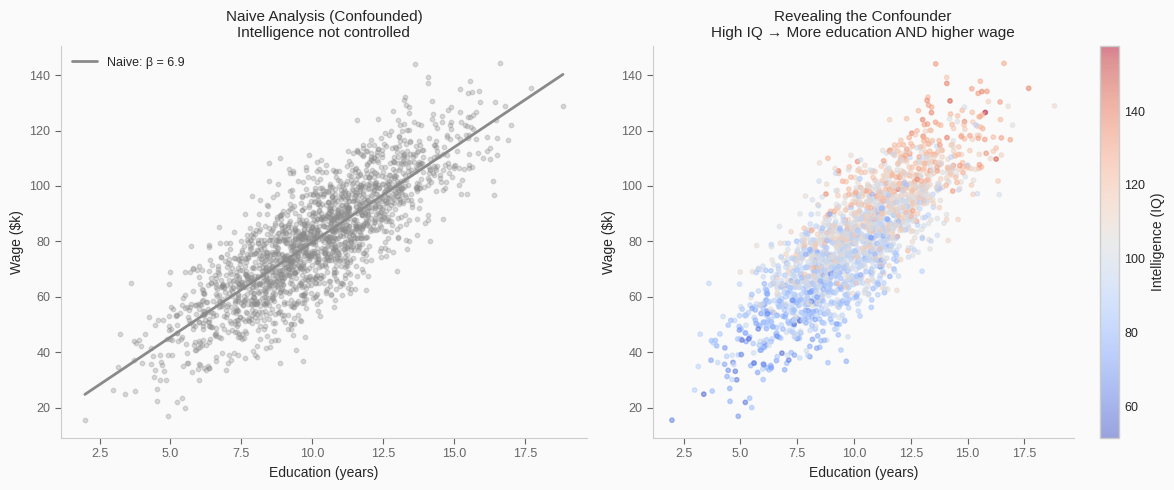

In [4]:
# Visualize the confounding
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Left: Naive relationship (confounded)
ax = axes[0]
ax.scatter(df['education'], df['wage'], alpha=0.3, s=10, c=TUFTE_PALETTE['secondary'])
# Add regression line
x_line = np.linspace(df['education'].min(), df['education'].max(), 100)
ax.plot(x_line, naive_model.params['const'] + naive_model.params['education'] * x_line,
        color=TUFTE_PALETTE['control'], linewidth=2, label=f'Naive: β = {naive_model.params["education"]:.1f}')
ax.set_xlabel('Education (years)')
ax.set_ylabel('Wage ($k)')
ax.set_title('Naive Analysis (Confounded)\nIntelligence not controlled')
ax.legend(frameon=False)

# Right: Color by intelligence to show confounding
ax = axes[1]
scatter = ax.scatter(df['education'], df['wage'], c=df['intelligence'], 
                     alpha=0.5, s=10, cmap='coolwarm')
plt.colorbar(scatter, ax=ax, label='Intelligence (IQ)')
ax.set_xlabel('Education (years)')
ax.set_ylabel('Wage ($k)')
ax.set_title('Revealing the Confounder\nHigh IQ → More education AND higher wage')

plt.tight_layout()
plt.show()

### 3.2 Surrogate Confounders

In [5]:
# What if intelligence is UNOBSERVED but we have a proxy (SAT scores)?
np.random.seed(42)

# SAT is caused by intelligence (surrogate/proxy)
sat_score = 1000 + 5 * (df['intelligence'] - 100) + np.random.normal(0, 100, n)
df['sat_score'] = sat_score

# Estimate with SAT as proxy
proxy_model = sm.OLS(df['wage'], sm.add_constant(df[['education', 'sat_score']])).fit()

print("SURROGATE CONFOUNDER ANALYSIS")
print("="*60)
print("If intelligence is unmeasured but SAT is available:")
print("-"*60)
print(f"True effect:              {TRUE_EFFECT:.2f}")
print(f"Naive (no control):       {naive_model.params['education']:.2f}")
print(f"With true confounder:     {adjusted_model.params['education']:.2f}")
print(f"With SAT proxy:           {proxy_model.params['education']:.2f}")
print("-"*60)
print("\nSAT partially controls for intelligence, reducing (but not eliminating) bias.")

SURROGATE CONFOUNDER ANALYSIS
If intelligence is unmeasured but SAT is available:
------------------------------------------------------------
True effect:              5.00
Naive (no control):       6.86
With true confounder:     5.18
With SAT proxy:           5.18
------------------------------------------------------------

SAT partially controls for intelligence, reducing (but not eliminating) bias.


In [6]:
# Demonstrate that multiple surrogates help
# Add another proxy: Father's education (correlated with child's intelligence)
father_edu = 10 + 0.05 * (df['intelligence'] - 100) + np.random.normal(0, 3, n)
df['father_edu'] = father_edu

multi_proxy_model = sm.OLS(df['wage'], 
                           sm.add_constant(df[['education', 'sat_score', 'father_edu']])).fit()

print("MULTIPLE SURROGATES")
print("="*60)
print(f"True effect:              {TRUE_EFFECT:.2f}")
print(f"With SAT only:            {proxy_model.params['education']:.2f}")
print(f"With SAT + Father Edu:    {multi_proxy_model.params['education']:.2f}")
print("-"*60)
print("Multiple proxies absorb more variance from the unobserved confounder.")

MULTIPLE SURROGATES
True effect:              5.00
With SAT only:            5.18
With SAT + Father Edu:    8.93
------------------------------------------------------------
Multiple proxies absorb more variance from the unobserved confounder.


---

## 4. Implementation

```python
# Basic regression adjustment
import statsmodels.api as sm

# Control for confounders
X = sm.add_constant(df[['treatment', 'confounder1', 'confounder2']])
model = sm.OLS(df['outcome'], X).fit()
ate = model.params['treatment']

# Using DoWhy for causal effect estimation
from dowhy import CausalModel

model = CausalModel(
    data=df,
    treatment='education',
    outcome='wage',
    common_causes=['intelligence', 'family_income'],
)
identified = model.identify_effect()
estimate = model.estimate_effect(identified, method_name="backdoor.linear_regression")
```

---

## 5. Interview Appendix

**Q1 (Uber, Lyft)**: *"What is confounding bias? How would you address it?"*

<details><summary>Solution</summary>

**Confounding bias** occurs when a common cause of treatment and outcome creates a spurious association.

**DAG**: X → T, X → Y, T → Y

**Solutions**:
1. **Randomization**: Break X → T link (gold standard)
2. **Regression adjustment**: Control for X
3. **Matching/Weighting**: Balance X across treatment groups
4. **Instrumental variables**: Find variable that affects T but not Y except through T
5. **Difference-in-differences**: Exploit within-unit variation over time

**Key insight**: The method must close all backdoor paths without opening new ones.

</details>

**Q2 (Meta, Google)**: *"What is the backdoor criterion?"*

<details><summary>Solution</summary>

The **backdoor criterion** (Pearl, 2009) specifies when a set of variables Z is sufficient to identify causal effects:

Z satisfies the backdoor criterion for (T, Y) if:
1. **No descendants of T**: Z doesn't include any variable on the causal path T → ... → Y
2. **Blocks backdoor paths**: Z blocks all paths T ← ... → Y (arrows into T)

If satisfied, the causal effect is:
$$E[Y|do(T)] = \sum_z E[Y|T,Z=z]P(Z=z)$$

**Why it matters**: It tells us exactly which variables to control for, avoiding both under-controlling (missing confounders) and over-controlling (conditioning on mediators or colliders).

</details>

**Q3**: *"If you can't measure a confounder directly, what can you do?"*

<details><summary>Solution</summary>

**Options for unmeasured confounders**:

1. **Proxy variables (surrogates)**: Variables caused by the confounder
   - Example: SAT scores as proxy for intelligence
   - Partial reduction in bias

2. **Instrumental variables**: Find IV that affects T but not Y directly
   - Example: Distance to college as IV for education

3. **Panel data / Fixed effects**: Control for time-invariant unobservables
   - Requires within-unit variation

4. **Sensitivity analysis**: Bound how bad bias could be
   - E.g., "How strong would unmeasured confounder need to be to explain away the effect?"

5. **Diff-in-diff / RDD**: Exploit natural experiments

**Key principle**: Acknowledge limitations, use multiple approaches, conduct sensitivity analysis.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 4.

[^2]: Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press, Chapter 3.

[^3]: Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 3.